In [1]:
import os
import sys
import argparse
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import scanpy as sc
import gseapy as gp
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/scanpy/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/scanpy/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/scanpy/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/scanpy/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/scanpy/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecat

In [2]:
wound_neutro = sc.read("wound_neutro_with_broad_type.h5ad")
wound_neutro.uns['broad_neutro_type_colors'] = ['#E18514', '#36AA7F']
# Subset the data to only include 24hr cells
wound_24hr = wound_neutro[wound_neutro.obs["time_point"] == "24hr"]
# Keep only blood-like and tissue-specific neutrophils
wound_24hr_bt = wound_24hr[wound_24hr.obs["broad_neutro_type"].isin(["Blood-like", "Tissue-like"])]

In [3]:
# Performing DGE between 24hr in tissue-like vs blood-like
sc.tl.rank_genes_groups(wound_24hr_bt, groupby="broad_neutro_type", method="wilcoxon")

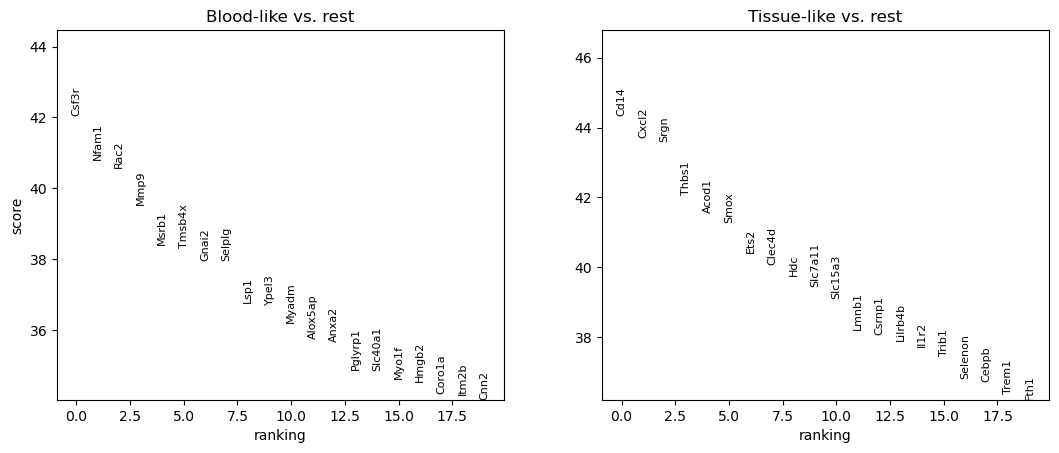

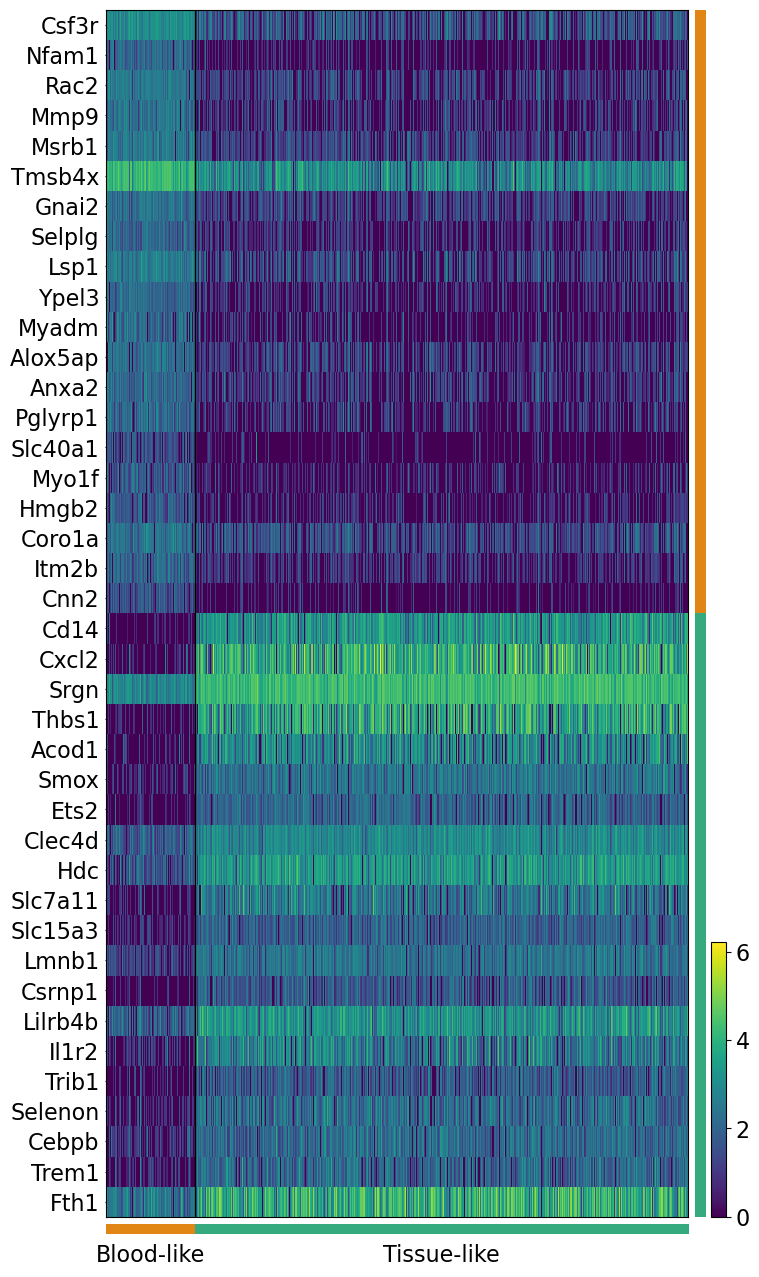

        gene      score  pval  pval_adj     logFC
Cd14    Cd14  44.347580   0.0       0.0  6.218880
Cxcl2  Cxcl2  43.706207   0.0       0.0  6.361734
Srgn    Srgn  43.585556   0.0       0.0  2.094965
Thbs1  Thbs1  42.066517   0.0       0.0  6.447645
Acod1  Acod1  41.549740   0.0       0.0  5.291301
...      ...        ...   ...       ...       ...
Msrb1  Msrb1 -38.397144   0.0       0.0 -2.351699
Mmp9    Mmp9 -39.527615   0.0       0.0 -2.988195
Rac2    Rac2 -40.581913   0.0       0.0 -2.634130
Nfam1  Nfam1 -40.803509   0.0       0.0 -3.664792
Csf3r  Csf3r -42.056599   0.0       0.0 -2.650282

[25223 rows x 5 columns]


In [4]:
# Visualise the results
sc.pl.rank_genes_groups(wound_24hr_bt, n_genes=20, sharey=False)
sc.pl.rank_genes_groups_heatmap(
    wound_24hr_bt,
    n_genes=20,
    groupby='broad_neutro_type',
    swap_axes=True,
    min_logfoldchange=0.25,
    dendrogram=False,
    show_gene_labels=True,
    figsize=(8, 16),
     show=False
)   
fig = plt.gcf()
for ax in fig.axes:
    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=16)
    if ax.get_ylabel() == '':
        ax.tick_params(axis='y', labelsize=16)
    if ax.get_xlabel() == "broad_neutro_type":
        ax.set_xlabel("")
axes = fig.get_axes()

plt.tight_layout()
plt.show()

# Extract results
tmp = wound_24hr_bt.uns['rank_genes_groups']

# Create a DataFrame with gene names, log2 fold change, p-values, and adjusted p-values
upreg = pd.DataFrame(
    index=tmp["names"]["Tissue-like"],  
    data={ 'gene': tmp['names']["Tissue-like"], 
          "score": tmp["scores"]["Tissue-like"],
          "pval": tmp["pvals"]["Tissue-like"],
          "pval_adj": tmp["pvals_adj"]["Tissue-like"],
          "logFC": tmp["logfoldchanges"]["Tissue-like"],
         },
)

print(upreg)

In [5]:
print("  Pathway analysis within 24hr neutros")
dwn_genes = upreg.loc[upreg["score"] < 0].index[::-1][:200]
up_genes = upreg.loc[upreg["score"] > 0].index[:200]


print("Downregulated in tissue-like")
enr_dwn = gp.enrichr(
    gene_list=list(dwn_genes),
    gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)

print("Upregulated in tissue-like")
enr_up = gp.enrichr(
    gene_list=list(up_genes),
    gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)


print("Gene sets in enrichment results:")
print(enr_up.results["Gene_set"].unique())

# Extract KEGG and GO-BP
def extract_pathways(enr_result, gene_set_name, label, top_n=50, min_log10_fdr=2):
    df = enr_result.results.copy()
    df = df[df["Gene_set"] == gene_set_name]
    df["-log10(FDR)"] = -np.log10(df["Adjusted P-value"])
    df = df[df["-log10(FDR)"] >= min_log10_fdr]
    df = df.nsmallest(top_n, "Adjusted P-value")
    df["Condition"] = label
    return df
def extract_pathways(enr_result, gene_set_name, label, top_n=50, min_log10_fdr=2):
    df = enr_result.results.copy()
    df = df[df["Gene_set"] == gene_set_name]
    df["-log10(FDR)"] = -np.log10(df["Adjusted P-value"])
    df = df[df["-log10(FDR)"] >= min_log10_fdr]
    df = df.nsmallest(top_n, "Adjusted P-value")
    df["Condition"] = label
    return df

# KEGG
kegg_up = extract_pathways(enr_up, "KEGG_2019_Mouse", "up in tissue-like")
kegg_dwn = extract_pathways(enr_dwn, "KEGG_2019_Mouse", "up in blood-like")

# GO-BP
go_up = extract_pathways(enr_up, "GO_Biological_Process_2023", "up in tissue-like")
go_up["Term"] = go_up["Term"].str.replace(r"\s*\(GO:\d+\)", "", regex=True)
go_dwn = extract_pathways(enr_dwn, "GO_Biological_Process_2023", "up in blood-like")
go_dwn["Term"] = go_dwn["Term"].str.replace(r"\s*\(GO:\d+\)", "", regex=True)

# Convert Overlap to numeric count
for df in [kegg_up, kegg_dwn, go_up, go_dwn]:
    df["Overlap"] = df["Overlap"].apply(lambda x: int(x.split("/")[0]))

# Sort KEGG results by significance for consistent plotting
kegg_up = kegg_up.sort_values("-log10(FDR)", ascending=False)
kegg_dwn = kegg_dwn.sort_values("-log10(FDR)", ascending=False)

# Set y-axis order to match sorting
kegg_up["Term"] = pd.Categorical(kegg_up["Term"], categories=kegg_up["Term"].unique()[::-1], ordered=True)
kegg_dwn["Term"] = pd.Categorical(kegg_dwn["Term"], categories=kegg_dwn["Term"].unique()[::-1], ordered=True)


  Pathway analysis within 24hr neutros
Downregulated in tissue-like
Upregulated in tissue-like
Gene sets in enrichment results:
['KEGG_2019_Mouse' 'GO_Biological_Process_2023']


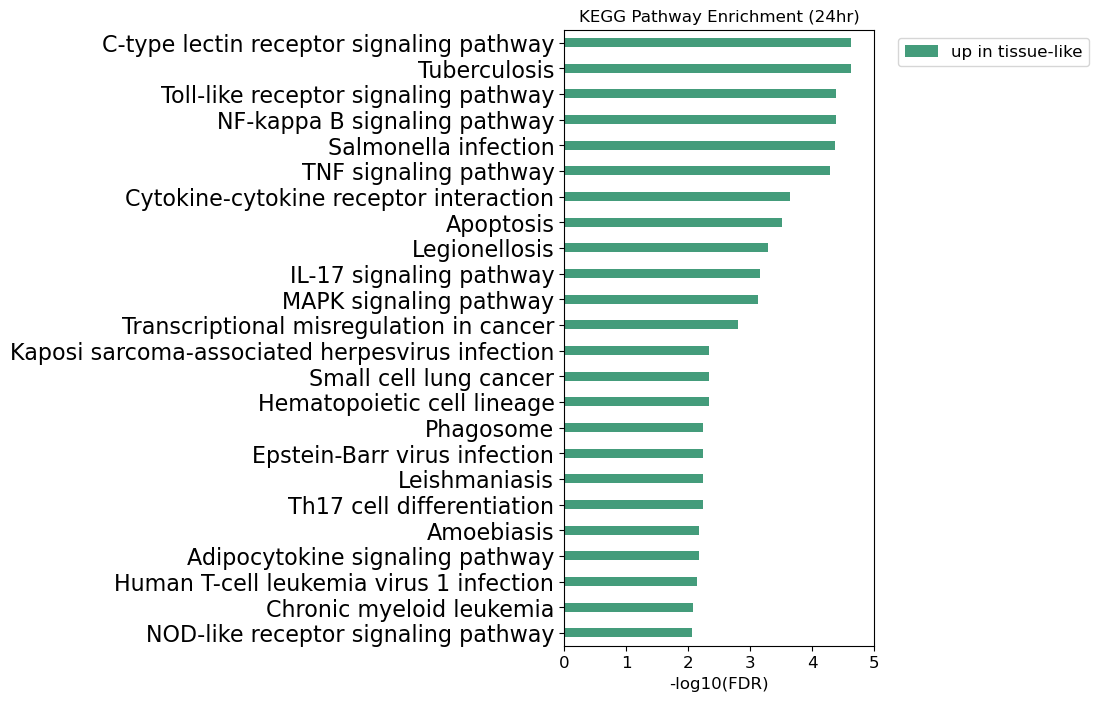

In [16]:
palette = {"up in blood-like": "#E18514", "up in tissue-like": "#36AA7F"}

# Plot KEGG
plt.figure(figsize=(4, 8))
sns.barplot(
    data=kegg_up,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    #size="Overlap",
    #sizes=(50, 200),
    #legend="full",
    palette=palette,
)
# Make the bars thinner
new_h = 0.35   # decrease this to make them thinner
for bar in plt.gca().patches:
    old_y = bar.get_y()
    old_h = bar.get_height()
    center = old_y + old_h / 2.0
    bar.set_height(new_h)
    bar.set_y(center - new_h / 2.0)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.title("KEGG Pathway Enrichment (24hr)", fontsize=12)
plt.xlabel("-log10(FDR)", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.gca().invert_yaxis() 
xmax = plt.gca().get_xlim()[1]
plt.xticks(ticks=np.arange(0, int(np.ceil(xmax)) + 1, 1), fontsize=12)
plt.show()

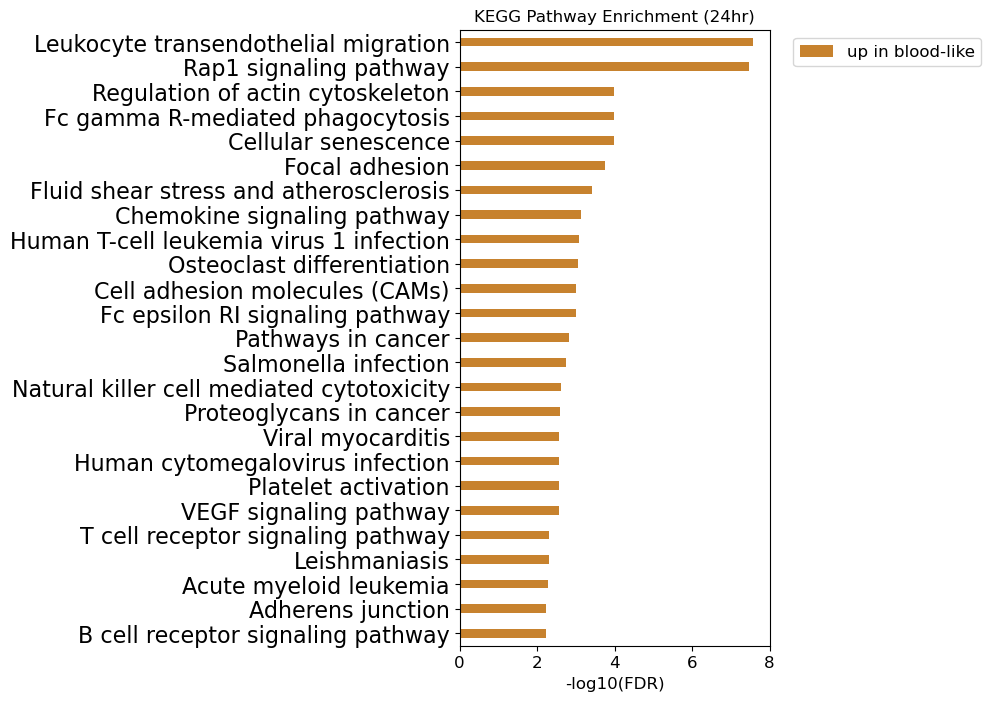

In [17]:
## palette = {"up in blood-like": "#E18514", "up in tissue-like": "#36AA7F"}
plt.figure(figsize=(4, 8))
sns.barplot(
    data=kegg_dwn,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    #size="Overlap",
    #sizes=(50, 200),
    #legend="full",
    palette=palette,
)
# Make the bars thinner
new_h = 0.35   # decrease this to make them thinner
for bar in plt.gca().patches:
    old_y = bar.get_y()
    old_h = bar.get_height()
    center = old_y + old_h / 2.0
    bar.set_height(new_h)
    bar.set_y(center - new_h / 2.0)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.title("KEGG Pathway Enrichment (24hr)", fontsize=12)
plt.xlabel("-log10(FDR)", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.gca().invert_yaxis() 
xmax = plt.gca().get_xlim()[1]
plt.xticks(ticks=np.arange(0, int(np.ceil(xmax)) + 1, 2), fontsize=12)
plt.show()


In [18]:
# Get raw gene string for Apoptosis from enr_up
apoptosis_genes_raw = enr_up.results[
    (enr_up.results["Term"] == "Apoptosis") &
    (enr_up.results["Gene_set"] == "KEGG_2019_Mouse")
]["Genes"].values[0]

# Convert to mouse-style gene symbols
apoptosis_genes_mouse = [gene.strip().capitalize() for gene in apoptosis_genes_raw.split(';')]

# Check the converted list
print("Converted Apoptosis genes to mouse-like format:")
print(apoptosis_genes_mouse)

Converted Apoptosis genes to mouse-like format:
['Nfkbia', 'Tuba1c', 'Bcl2l11', 'Gadd45b', 'Csf2rb', 'Tnf', 'Actg1', 'Bcl2l1', 'Lmnb1']


In [19]:
# Match converted genes to genes in your dataset
valid_apoptosis_genes = [gene for gene in apoptosis_genes_mouse if gene in wound_24hr_bt.var_names]
print(f"{len(valid_apoptosis_genes)} apoptosis pathway genes matched in the dataset.")
print("Matched genes:", valid_apoptosis_genes)


9 apoptosis pathway genes matched in the dataset.
Matched genes: ['Nfkbia', 'Tuba1c', 'Bcl2l11', 'Gadd45b', 'Csf2rb', 'Tnf', 'Actg1', 'Bcl2l1', 'Lmnb1']


In [20]:
X_apoptosis = wound_24hr_bt[:, valid_apoptosis_genes].X
X_binary = (X_apoptosis > 0).astype(int)
apoptosis_gene_count = np.array(X_binary.sum(axis=1)).flatten()

# Count how many cells express ≥ 2 apoptosis genes
threshold = 2
cells_with_apoptosis = np.sum(apoptosis_gene_count >= threshold)

print(f"{cells_with_apoptosis} cells express at least {threshold} apoptosis genes.")


5289 cells express at least 2 apoptosis genes.


In [21]:
# Sort GO-BP results by significance for consistent plotting
go_up = go_up.sort_values("-log10(FDR)", ascending=False)
go_dwn = go_dwn.sort_values("-log10(FDR)", ascending=False)

# Set y-axis order to match sorting
go_up["Term"] = pd.Categorical(go_up["Term"], categories=go_up["Term"].unique()[::-1], ordered=True)
go_dwn = go_dwn.dropna(subset=["Term"])
go_dwn["Term"] = pd.Categorical(
    go_dwn["Term"], 
    categories=go_dwn["Term"].unique()[::-1], 
    ordered=True
)

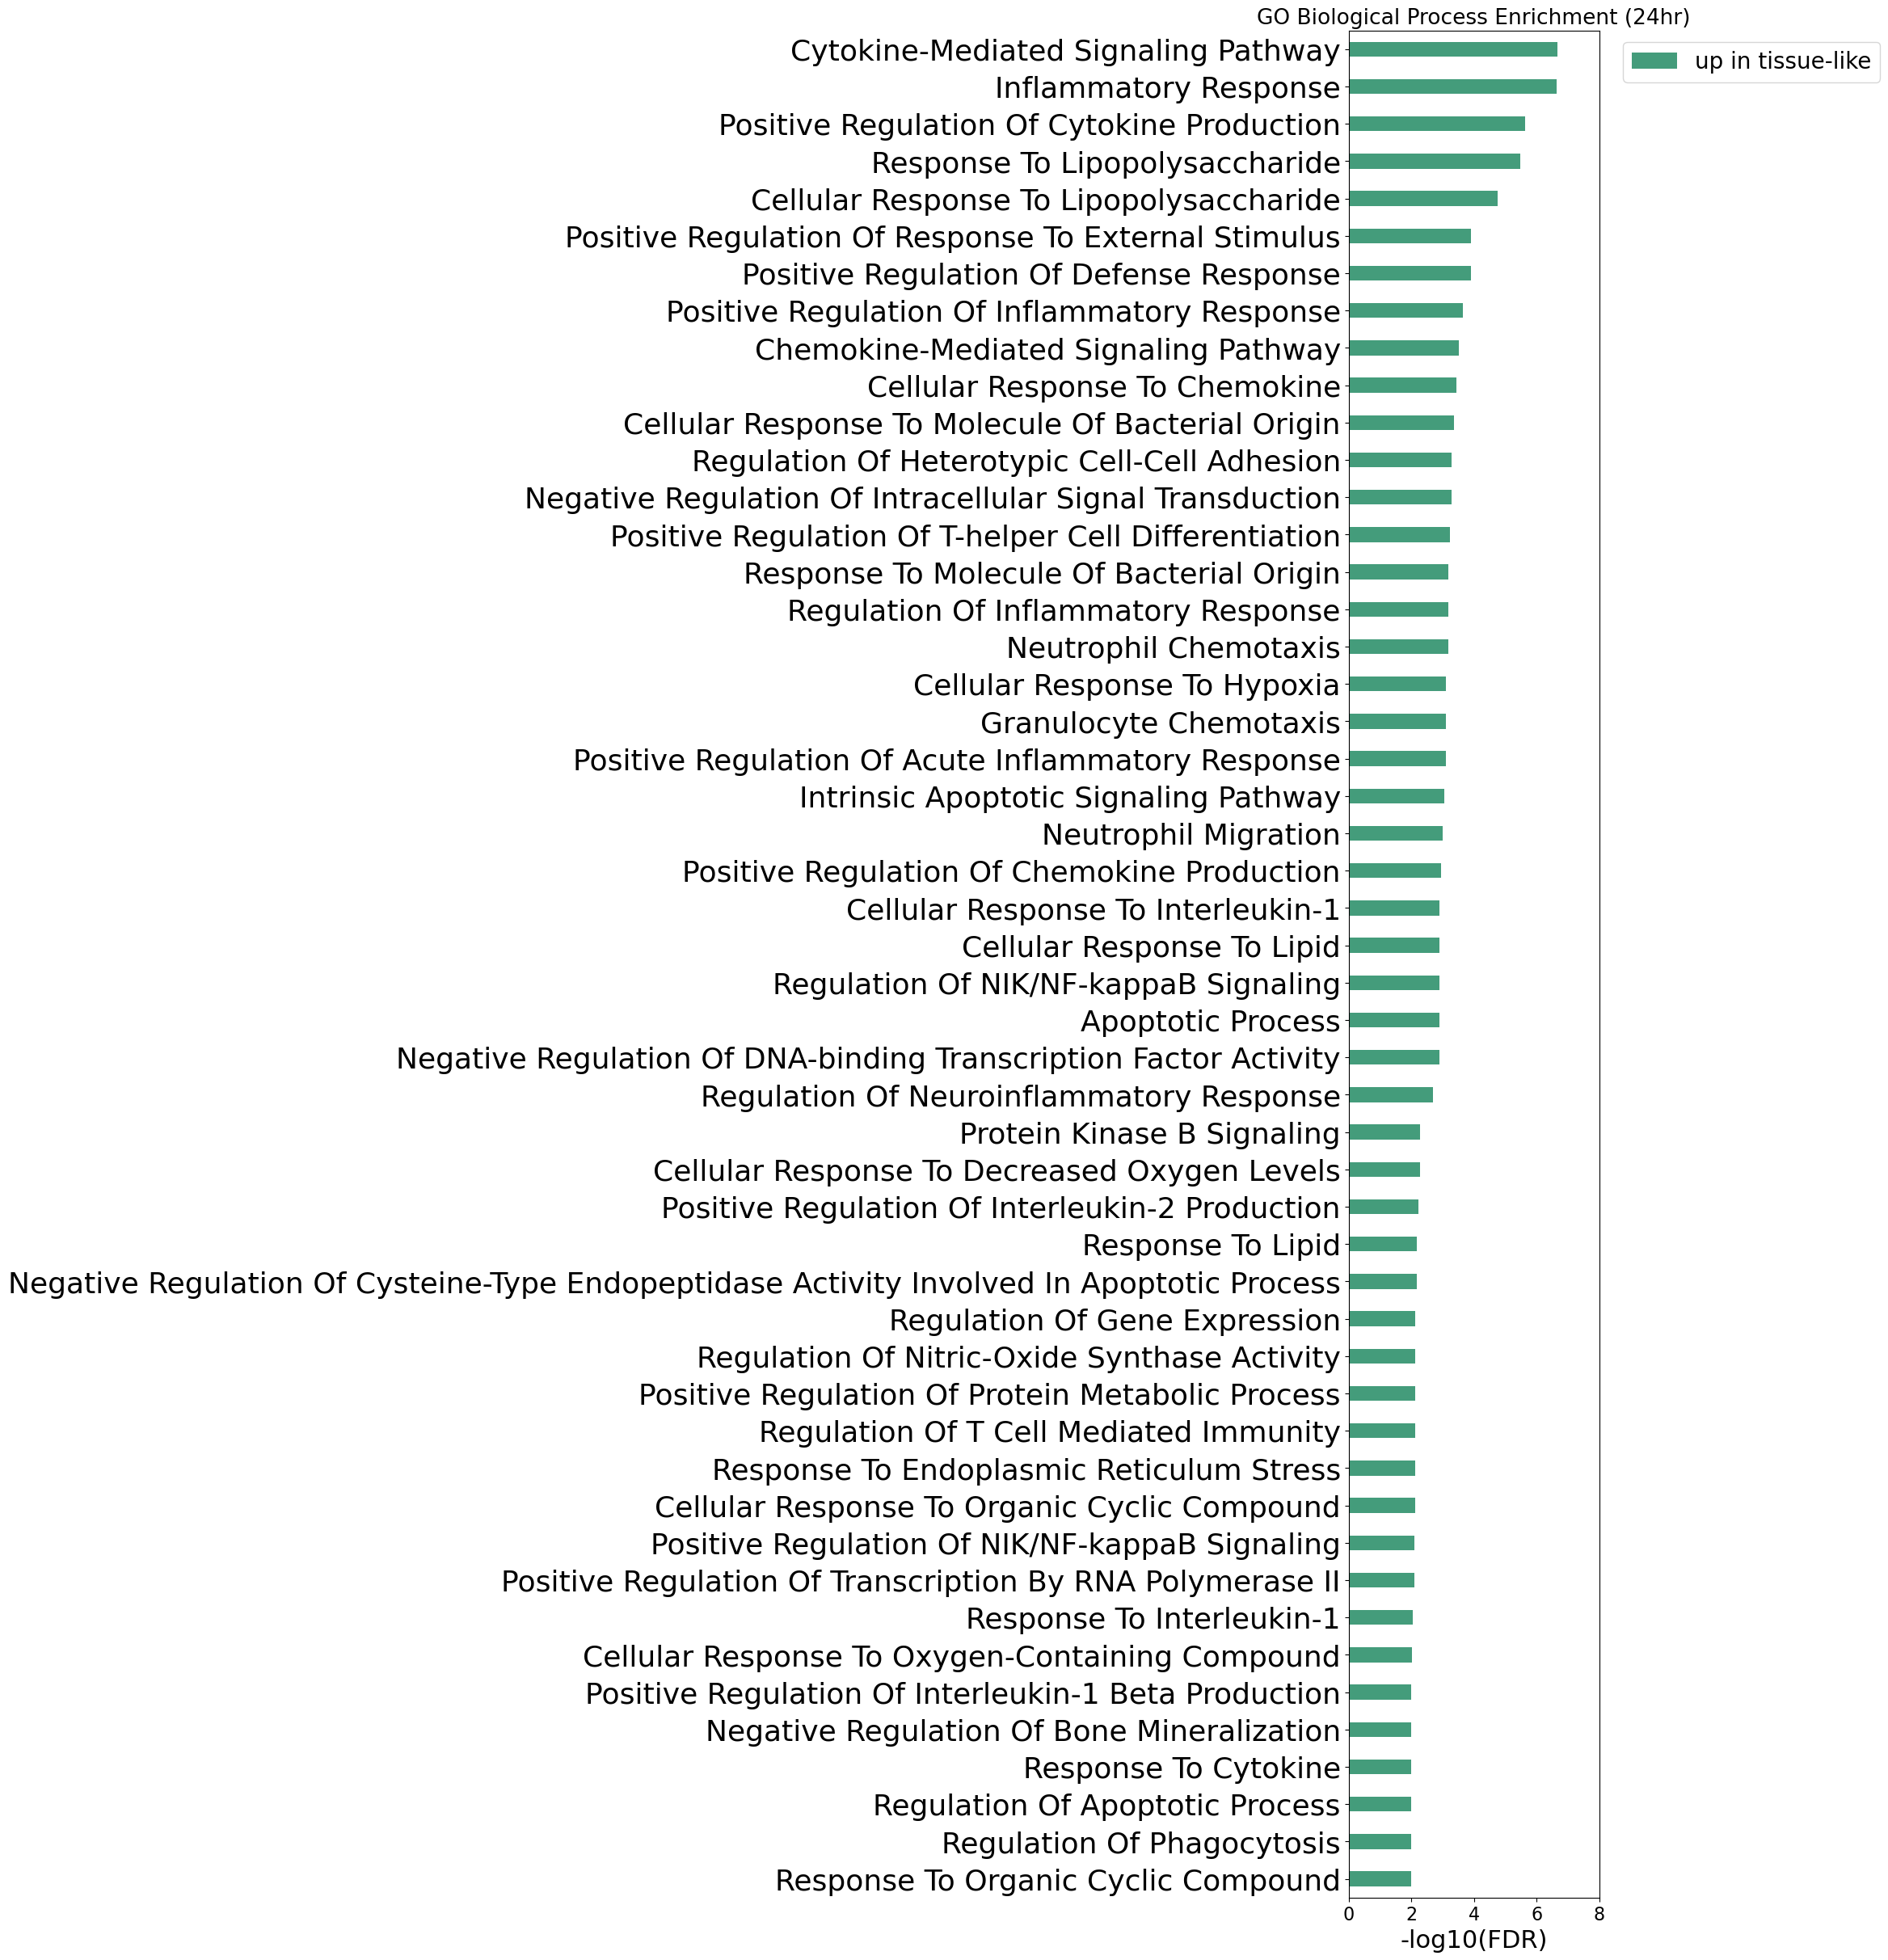

In [29]:
# Plot GO-BP with extra space
plt.figure(figsize=(4, 30))
sns.barplot(
    data=go_up,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    #size="Overlap",
    #sizes=(50, 200),
    #legend="full",
    palette=palette,
)
# Make the bars thinner
new_h = 0.4   # decrease this to make them thinner
for bar in plt.gca().patches:
    old_y = bar.get_y()
    old_h = bar.get_height()
    center = old_y + old_h / 2.0
    bar.set_height(new_h)
    bar.set_y(center - new_h / 2.0)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.title("GO Biological Process Enrichment (24hr)", fontsize=19)
plt.xlabel("-log10(FDR)", fontsize=22)
plt.ylabel("")
plt.xticks(fontsize=16)
plt.yticks(fontsize=26)
plt.gca().invert_yaxis()
xmax = plt.gca().get_xlim()[1]
plt.xticks(ticks=np.arange(0, int(np.ceil(xmax)) + 1, 2), fontsize=16)
plt.show()

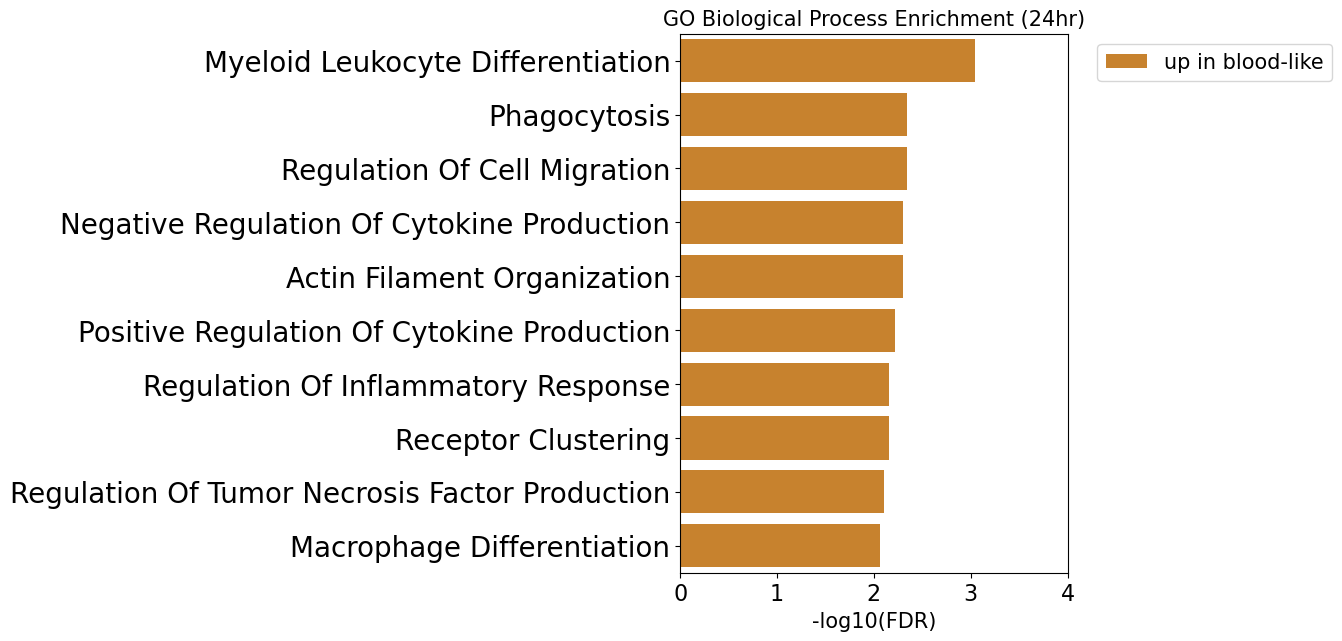

In [31]:
# Plot GO-BP
plt.figure(figsize=(5, 7))
sns.barplot(
    data=go_dwn,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    #size="Overlap",
    #sizes=(50, 200),
    #legend="full",
    palette=palette,
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
plt.title("GO Biological Process Enrichment (24hr)", fontsize=15)
plt.xlabel("-log10(FDR)", fontsize=15)
plt.ylabel("")
plt.xticks(fontsize=16)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()
xmax = plt.gca().get_xlim()[1]
plt.xticks(ticks=np.arange(0, int(np.ceil(xmax)) + 1, 1), fontsize=16)
plt.show()

In [66]:
sc.tl.rank_genes_groups(wound_24hr_bt, groupby="broad_neutro_type", method="wilcoxon")
top_24bt_genes=sc.get.rank_genes_groups_df(
   wound_24hr_bt,
    group=None,
    log2fc_min=0.25,
    pval_cutoff=0.05
)
top_20=top_24bt_genes.groupby("group").head(20)["names"].unique().tolist()
print(top_20)

['Csf3r', 'Nfam1', 'Rac2', 'Mmp9', 'Msrb1', 'Tmsb4x', 'Gnai2', 'Selplg', 'Lsp1', 'Ypel3', 'Myadm', 'Alox5ap', 'Anxa2', 'Pglyrp1', 'Slc40a1', 'Myo1f', 'Hmgb2', 'Coro1a', 'Itm2b', 'Cnn2', 'Cd14', 'Cxcl2', 'Srgn', 'Thbs1', 'Acod1', 'Smox', 'Ets2', 'Clec4d', 'Hdc', 'Slc7a11', 'Slc15a3', 'Lmnb1', 'Csrnp1', 'Lilrb4b', 'Il1r2', 'Trib1', 'Selenon', 'Cebpb', 'Trem1', 'Fth1']


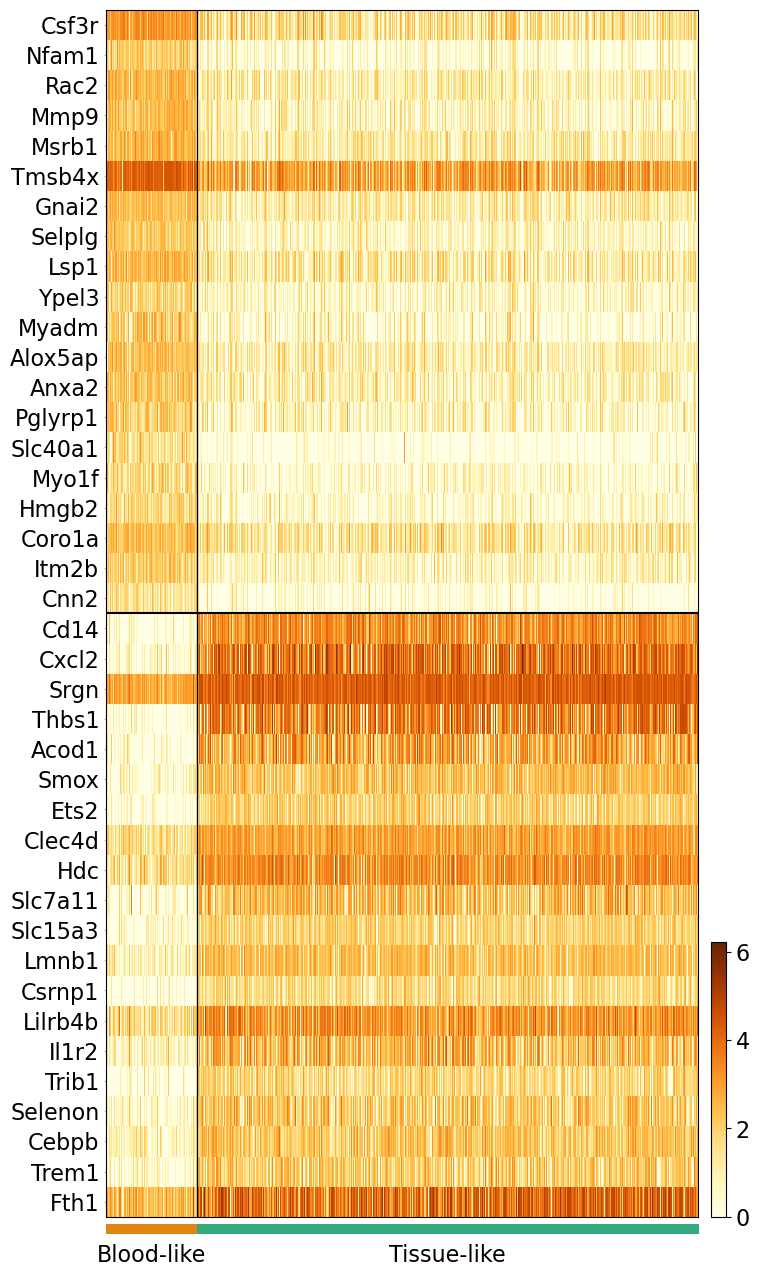

In [77]:
sc.pl.heatmap(
    wound_24hr_bt,
    var_names=top_20,
    groupby="broad_neutro_type",
    cmap="YlOrBr",
    standard_scale=None,
    swap_axes=True,
    show_gene_labels=True,
    dendrogram=False,
    figsize=(8,16),
    show=False
)
fig = plt.gcf()
for ax in fig.axes:
    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=16)
    if ax.get_ylabel() == '':
        ax.tick_params(axis='y', labelsize=16)
    if ax.get_xlabel() == "broad_neutro_type":
        ax.set_xlabel("")
axes = fig.get_axes()
axes[0].axhline(19.5, color="black")
#axes[0].axvline(6350.5, color="black", linewidth=0.7)
plt.tight_layout()
plt.show()


In [11]:
# Extract DGE results: 
# A positive logFC means the gene is more highly expressed in Tissue-like neutrophils at 24hr compared to blood-like neutrophils at 24hr.
# A negative logFC means it is higher in blood-like.
deg_24hr_bt = sc.get.rank_genes_groups_df(wound_24hr_bt, group='Tissue-like')
deg_24hr_bt.to_csv("24hr_tissue_vs_blood_like.csv", index=False)

In [12]:
# Check mean expression for top gene
top_gene = deg_24hr_bt.iloc[0]["names"]
x_tissue = wound_24hr_bt[wound_24hr_bt.obs["broad_neutro_type"] == "Tissue-like", top_gene].X.mean()
x_blood = wound_24hr_bt[wound_24hr_bt.obs["broad_neutro_type"] == "Blood-like", top_gene].X.mean()
print(f"{top_gene} expression: Tissue-like = {x_tissue:.2f}, Blood-like = {x_blood:.2f}")

Cd14 expression: Tissue-like = 3.14, Blood-like = 0.26


In [15]:
## Load your CSV file
import pandas as pd

deg = pd.read_csv("24hr_tissue_vs_blood_like.csv")

# Apply filtering thresholds
filtered_deg = deg[
    (deg["pvals_adj"] < 0.01) & (abs(deg["logfoldchanges"]) > 1)
]

# Save filtered results (optional)
filtered_deg.to_csv("Filtered_24hr_TvsB.csv", index=False)
# Upregulated genes in tissue-like:
filtered_deg_up = filtered_deg[filtered_deg["logfoldchanges"] > 1]
# Upregulated genes in blood-like:
filtered_deg_down = filtered_deg[filtered_deg["logfoldchanges"] < -1]

In [21]:
# Sort upregulated in tissue-like by descending logFC
top_50_up = filtered_deg.sort_values(
    by=["logfoldchanges", "pvals_adj"], ascending=[False, True]
).head(50)

# Sort upregulated in blood-like by ascending logFC (more negative = more downregulated)
top_50_down = filtered_deg.sort_values(
    by=["logfoldchanges", "pvals_adj"], ascending=[True, True]
).head(50)

top_50_up.to_csv("top_50_up_T24.csv", index=False)
top_50_down.to_csv("top_50_up_B24.csv", index=False)

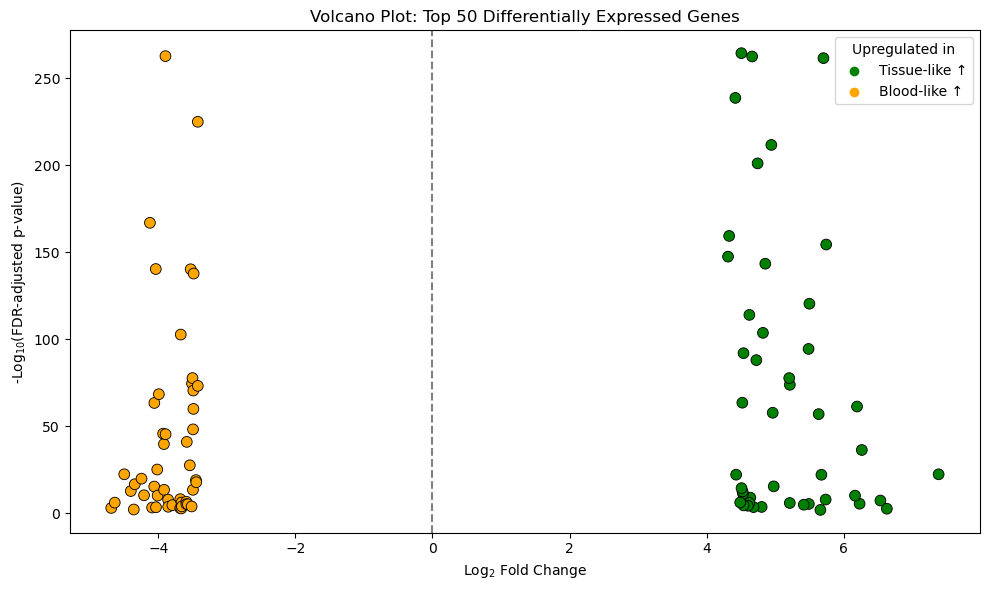

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load top 50 upregulated in tissue-like and blood-like
top_50_up = pd.read_csv("top_50_up_T24.csv")
top_50_down = pd.read_csv("top_50_up_B24.csv")

# Combine both dataframes
volcano_df = pd.concat([top_50_up, top_50_down], ignore_index=True)

# Add -log10(p-value) column
volcano_df["neg_log10_pval"] = -np.log10(volcano_df["pvals_adj"])

# Define regulation direction for coloring
volcano_df["regulation"] = volcano_df["logfoldchanges"].apply(
    lambda x: "Tissue-like ↑" if x > 0 else "Blood-like ↑"
)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=volcano_df,
    x="logfoldchanges",
    y="neg_log10_pval",
    hue="regulation",
    palette={"Tissue-like ↑": "green", "Blood-like ↑": "orange"},
    s=60,
    edgecolor="black"
)

plt.axvline(x=0, linestyle="--", color="gray")
plt.xlabel("Log$_2$ Fold Change")
plt.ylabel("-Log$_{10}$(FDR-adjusted p-value)")
plt.title("Volcano Plot: Top 50 Differentially Expressed Genes")
plt.legend(title="Upregulated in")
plt.tight_layout()
plt.show()


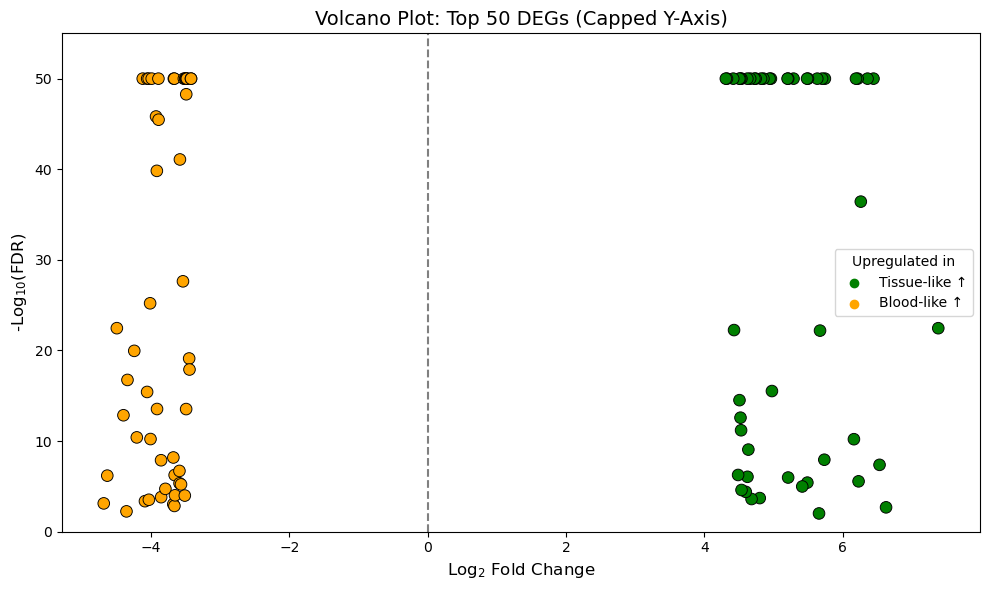

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load your data
top_50_up = pd.read_csv("top_50_up_T24.csv")
top_50_down = pd.read_csv("top_50_up_B24.csv")

# Combine
volcano_df = pd.concat([top_50_up, top_50_down], ignore_index=True)

# Avoid log(0): add a small epsilon
epsilon = 1e-300
volcano_df["neg_log10_pval"] = -np.log10(volcano_df["pvals_adj"] + epsilon)

# Cap the y-axis to improve readability
volcano_df["neg_log10_pval"] = volcano_df["neg_log10_pval"].clip(upper=50)

# Define groups
volcano_df["regulation"] = volcano_df["logfoldchanges"].apply(
    lambda x: "Tissue-like ↑" if x > 0 else "Blood-like ↑"
)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=volcano_df,
    x="logfoldchanges",
    y="neg_log10_pval",
    hue="regulation",
    palette={"Tissue-like ↑": "green", "Blood-like ↑": "orange"},
    s=70,
    edgecolor="black"
)

plt.axvline(x=0, linestyle="--", color="gray")
plt.xlabel("Log$_2$ Fold Change", fontsize=12)
plt.ylabel("-Log$_{10}$(FDR)", fontsize=12)
plt.title("Volcano Plot: Top 50 DEGs (Capped Y-Axis)", fontsize=14)
plt.ylim(0, 55)
plt.legend(title="Upregulated in")
plt.tight_layout()
plt.show()


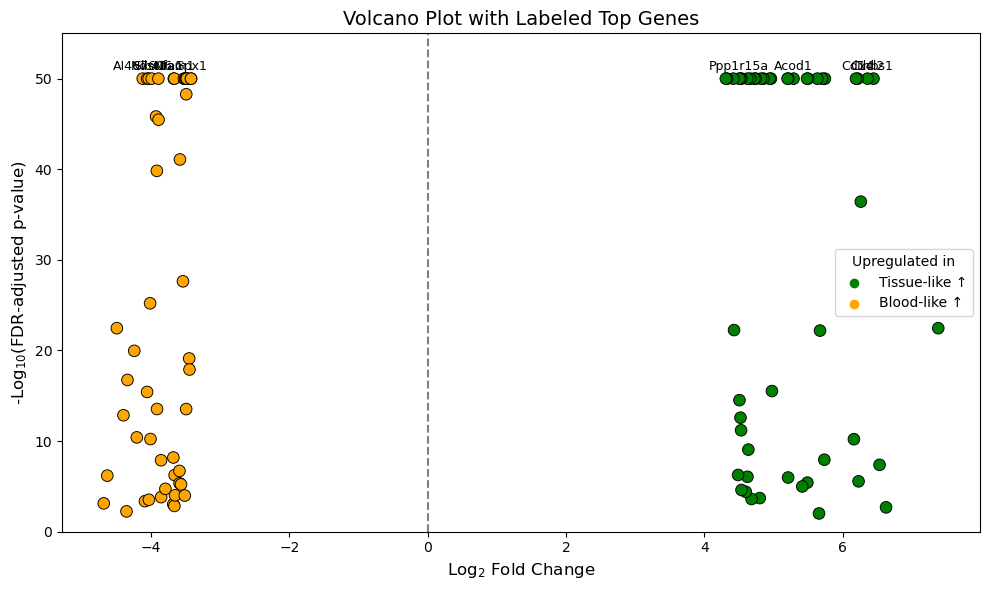

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Load your CSV files ===
top_50_up = pd.read_csv("top_50_up_T24.csv")
top_50_down = pd.read_csv("top_50_up_B24.csv")

# === Combine both datasets ===
volcano_df = pd.concat([top_50_up, top_50_down], ignore_index=True)

# === Calculate -log10(p-value), avoid log(0) ===
epsilon = 1e-300
volcano_df["neg_log10_pval"] = -np.log10(volcano_df["pvals_adj"] + epsilon)
volcano_df["neg_log10_pval"] = volcano_df["neg_log10_pval"].clip(upper=50)

# === Mark regulation group ===
volcano_df["regulation"] = volcano_df["logfoldchanges"].apply(
    lambda x: "Tissue-like ↑" if x > 0 else "Blood-like ↑"
)

# === Select top 5 genes with lowest p-value in each group ===
top_label_up = volcano_df[volcano_df["logfoldchanges"] > 0].nsmallest(5, "pvals_adj")
top_label_down = volcano_df[volcano_df["logfoldchanges"] < 0].nsmallest(5, "pvals_adj")

# === Plot ===
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=volcano_df,
    x="logfoldchanges",
    y="neg_log10_pval",
    hue="regulation",
    palette={"Tissue-like ↑": "green", "Blood-like ↑": "orange"},
    s=70,
    edgecolor="black"
)

# === Add labels to top genes ===
for _, row in pd.concat([top_label_up, top_label_down]).iterrows():
    plt.text(
        row["logfoldchanges"],
        row["neg_log10_pval"] + 1,
        row["names"],
        fontsize=9,
        ha='center'
    )

# === Final plot aesthetics ===
plt.axvline(x=0, linestyle="--", color="gray")
plt.xlabel("Log$_2$ Fold Change", fontsize=12)
plt.ylabel("-Log$_{10}$(FDR-adjusted p-value)", fontsize=12)
plt.title("Volcano Plot with Labeled Top Genes", fontsize=14)
plt.ylim(0, 55)
plt.legend(title="Upregulated in")
plt.tight_layout()
plt.show()


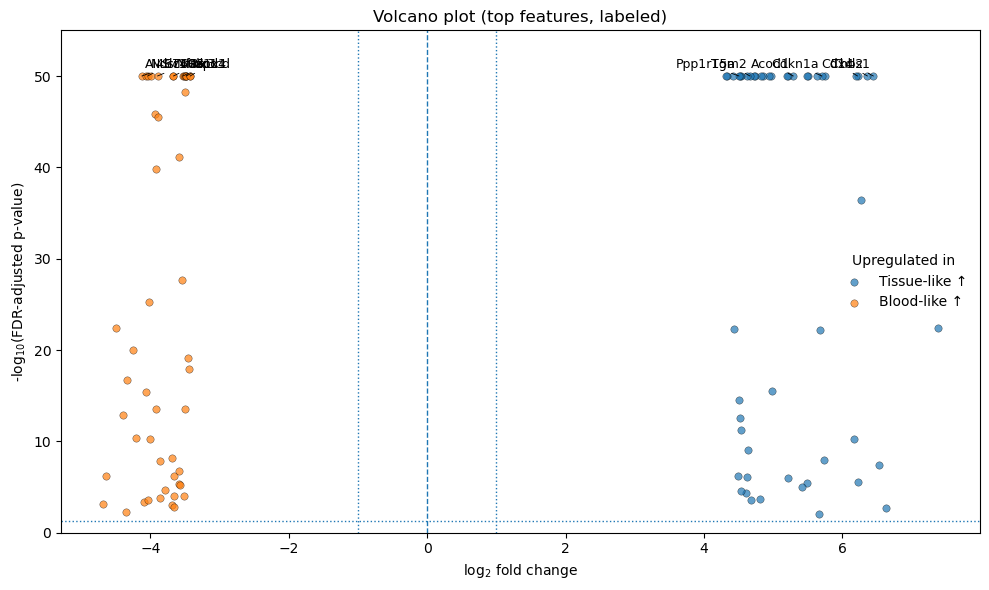

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load data ===
top_50_up = pd.read_csv("top_50_up_T24.csv")
top_50_down = pd.read_csv("top_50_up_B24.csv")  # <- if this is a typo, fix the filename

# === Combine and compute stats ===
volcano_df = pd.concat([top_50_up, top_50_down], ignore_index=True)

epsilon = 1e-300
volcano_df["neg_log10_padj"] = -np.log10(volcano_df["pvals_adj"].clip(lower=epsilon))
volcano_df["neg_log10_padj"] = volcano_df["neg_log10_padj"].clip(upper=50)

# Mark group
volcano_df["regulation"] = np.where(
    volcano_df["logfoldchanges"] > 0, "Tissue-like ↑", "Blood-like ↑"
)

# === Choose top labels (lowest FDR within each side) ===
n_labels = 7  # tweak if you want more/less labels
top_up = (volcano_df[volcano_df["logfoldchanges"] > 0]
          .nsmallest(n_labels, "pvals_adj"))
top_down = (volcano_df[volcano_df["logfoldchanges"] < 0]
            .nsmallest(n_labels, "pvals_adj"))
to_label = pd.concat([top_up, top_down]).drop_duplicates(subset=["names"])

# === Plot ===
plt.figure(figsize=(10, 6))

# Points (draw one group at a time for distinct legend entries)
for grp in ["Tissue-like ↑", "Blood-like ↑"]:
    sub = volcano_df[volcano_df["regulation"] == grp]
    plt.scatter(
        sub["logfoldchanges"],
        sub["neg_log10_padj"],
        s=28, alpha=0.7, linewidths=0.3, edgecolors="black",
        label=grp
    )

# Threshold guides (customize as needed)
logfc_thr = 1.0              # ~2-fold
padj_thr = 0.05
plt.axvline(0, linestyle="--", linewidth=1)
plt.axvline(logfc_thr, linestyle=":", linewidth=1)
plt.axvline(-logfc_thr, linestyle=":", linewidth=1)
plt.axhline(-np.log10(padj_thr), linestyle=":", linewidth=1)

# Labels for selected genes (with small offsets to reduce collisions)
y_offset = 0.6
for i, row in to_label.iterrows():
    x, y = row["logfoldchanges"], row["neg_log10_padj"]
    # place label slightly above and left/right depending on side
    dx = -0.05 if x > 0 else 0.05
    plt.annotate(
        row["names"],
        xy=(x, y),
        xytext=(x + dx, y + y_offset),
        arrowprops=dict(arrowstyle="-", lw=0.6, shrinkA=0, shrinkB=0),
        fontsize=9, ha="right" if x > 0 else "left", va="bottom"
    )

# Aesthetics
plt.xlabel("log$_2$ fold change")
plt.ylabel("-log$_{10}$(FDR-adjusted p-value)")
plt.title("Volcano plot (top features, labeled)")
plt.ylim(0, 55)
plt.legend(title="Upregulated in", frameon=False)
plt.tight_layout()
plt.show()


In [27]:
# Sort upregulated in tissue-like by descending logFC
top_500_up = filtered_deg.sort_values(
    by=["logfoldchanges", "pvals_adj"], ascending=[False, True]
).head(300)

# Sort upregulated in blood-like by ascending logFC (more negative = more downregulated)
top_500_down = filtered_deg.sort_values(
    by=["logfoldchanges", "pvals_adj"], ascending=[True, True]
).head(300)

top_500_up.to_csv("top_500_up_T24.csv", index=False)
top_500_down.to_csv("top_500_up_B24.csv", index=False)

In [72]:
wound_7day = wound_neutro[wound_neutro.obs["time_point"] == "7day"]
# Keep only blood-like and tissue-specific neutrophils
wound_7day_bt = wound_7day[wound_7day.obs["broad_neutro_type"].isin(["Blood-like", "Tissue-like"])]

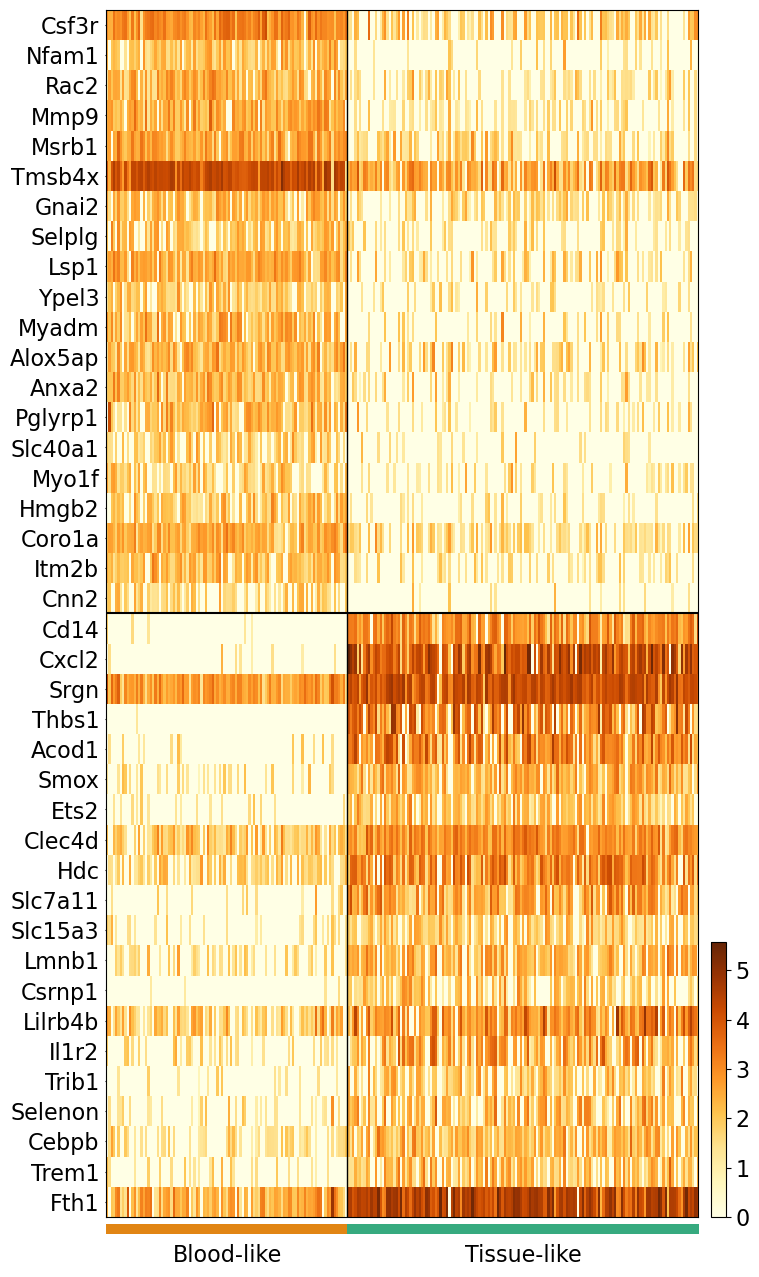

In [78]:
gene_bt_7day=['Csf3r','Nfam1','Rac2','Mmp9','Msrb1','Tmsb4x','Gnai2','Selplg','Lsp1','Ypel3',
             'Myadm','Alox5ap','Anxa2','Pglyrp1','Slc40a1','Myo1f','Hmgb2','Coro1a','Itm2b','Cnn2',
             'Cd14','Cxcl2','Srgn','Thbs1','Acod1','Smox','Ets2','Clec4d','Hdc','Slc7a11',
             'Slc15a3','Lmnb1','Csrnp1','Lilrb4b','Il1r2','Trib1','Selenon','Cebpb','Trem1','Fth1']

sc.pl.heatmap(
    wound_7day_bt,
    var_names=gene_bt_7day,
    groupby="broad_neutro_type",
    cmap="YlOrBr",
    standard_scale=None,  # optional: z-score across cells per gene
    swap_axes=True,
    figsize=(8, 16),
    dendrogram=False,
    show=False
)
fig = plt.gcf()
for ax in fig.axes:
    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=16)
    if ax.get_ylabel() == '':
        ax.tick_params(axis='y', labelsize=16)
    if ax.get_xlabel() == "broad_neutro_type":
        ax.set_xlabel("")
axes = fig.get_axes()
axes[0].axhline(19.5, color="black")
#axes[0].axvline(6350.5, color="black", linewidth=0.7)
plt.tight_layout()
plt.show()


In [79]:
wound_7day_bt.obs["broad_neutro_type"].value_counts()

broad_neutro_type
Tissue-like    153
Blood-like     105
Name: count, dtype: int64

In [76]:
wound_neutro = sc.read("wound_neutro_with_broad_type.h5ad")
wound_neutro.uns['broad_neutro_type_colors'] = ['#E18514', '#36AA7F']
# Subset the data to only include 24hr cells
wound_7day = wound_neutro[wound_neutro.obs["time_point"] == "7day"]
# Keep only blood-like and tissue-specific neutrophils
wound_7day_bt = wound_7day[wound_7day.obs["broad_neutro_type"].isin(["Blood-like", "Tissue-like"])]

In [86]:
wound_7day_bt.obs["broad_neutro_type"].value_counts()

broad_neutro_type
Tissue-like    153
Blood-like     105
Name: count, dtype: int64

In [77]:
# Performing DGE between 7day in tissue-like vs blood-like
sc.tl.rank_genes_groups(wound_7day_bt, groupby="broad_neutro_type", method="wilcoxon")

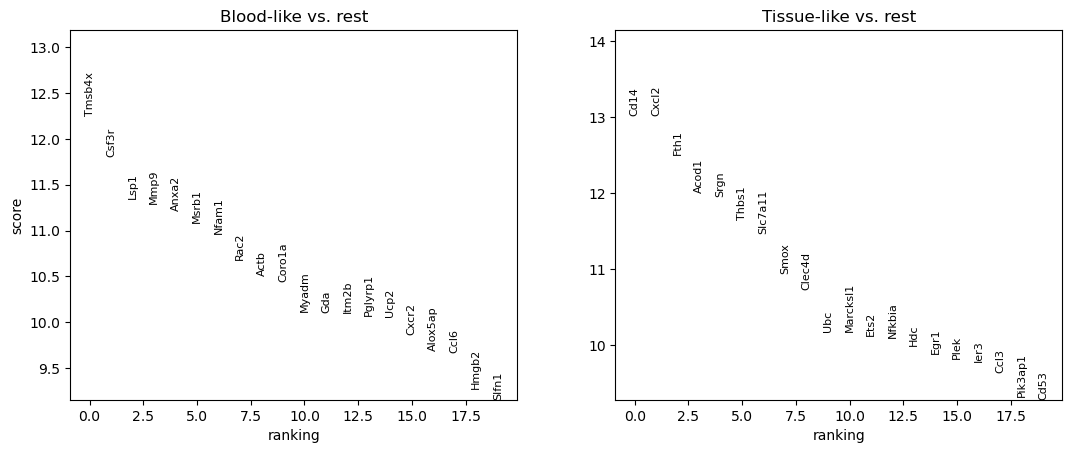

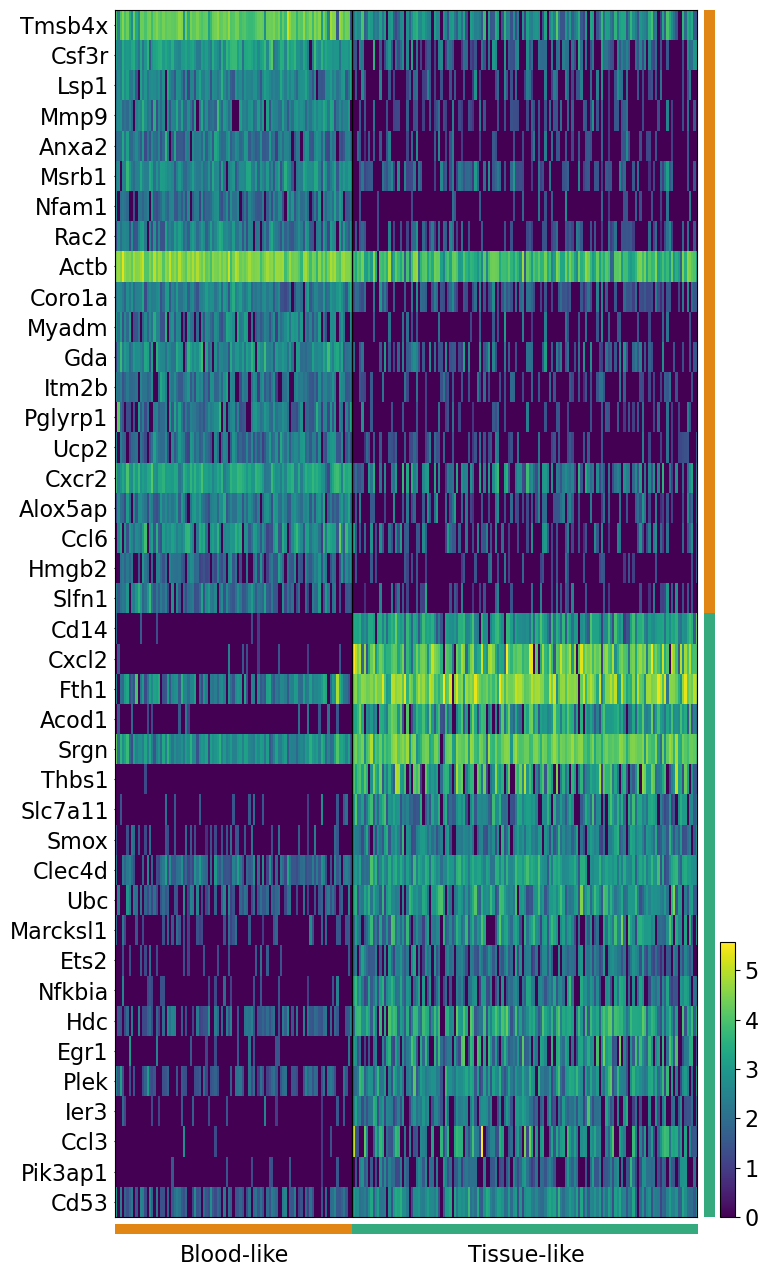

          gene      score          pval      pval_adj     logFC
Cd14      Cd14  13.024691  8.855889e-39  1.129353e-34  7.773336
Cxcl2    Cxcl2  13.023842  8.954949e-39  1.129353e-34  8.502748
Fth1      Fth1  12.510122  6.572263e-36  5.525740e-32  3.169801
Acod1    Acod1  12.005744  3.314699e-33  1.672133e-29  6.090958
Srgn      Srgn  11.953947  6.191306e-33  2.602722e-29  1.987445
...        ...        ...           ...           ...       ...
Anxa2    Anxa2 -11.216060  3.400875e-29  7.148355e-26 -3.468441
Mmp9      Mmp9 -11.289084  1.485762e-29  3.406852e-26 -3.384423
Lsp1      Lsp1 -11.343429  7.994981e-30  2.016574e-26 -3.355281
Csf3r    Csf3r -11.802804  3.775203e-32  1.360313e-28 -2.975347
Tmsb4x  Tmsb4x -12.256235  1.555611e-34  9.809294e-31 -2.671419

[25223 rows x 5 columns]


In [78]:
# Visualise the results
sc.pl.rank_genes_groups(wound_7day_bt, n_genes=20, sharey=False)
sc.pl.rank_genes_groups_heatmap(
    wound_7day_bt,
    n_genes=20,
    groupby='broad_neutro_type',
    swap_axes=True,
    min_logfoldchange=0.25,
    dendrogram=False,
    show_gene_labels=True,
    figsize=(8, 16),
     show=False
)   
fig = plt.gcf()
for ax in fig.axes:
    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=16)
    if ax.get_ylabel() == '':
        ax.tick_params(axis='y', labelsize=16)
    if ax.get_xlabel() == "broad_neutro_type":
        ax.set_xlabel("")
axes = fig.get_axes()

plt.tight_layout()
plt.show()

# Extract results
tmp = wound_7day_bt.uns['rank_genes_groups']

# Create a DataFrame with gene names, log2 fold change, p-values, and adjusted p-values
upreg = pd.DataFrame(
    index=tmp["names"]["Tissue-like"],  
    data={ 'gene': tmp['names']["Tissue-like"], 
          "score": tmp["scores"]["Tissue-like"],
          "pval": tmp["pvals"]["Tissue-like"],
          "pval_adj": tmp["pvals_adj"]["Tissue-like"],
          "logFC": tmp["logfoldchanges"]["Tissue-like"],
         },
)

print(upreg)


In [80]:
print("  Pathway analysis within 7day neutros")
dwn_genes = upreg.loc[upreg["score"] < 0].index[::-1][:200]
up_genes = upreg.loc[upreg["score"] > 0].index[:200]


print("Downregulated in tissue-like")
enr_dwn = gp.enrichr(
    gene_list=list(dwn_genes),
    gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)

print("Upregulated in tissue-like")
enr_up = gp.enrichr(
    gene_list=list(up_genes),
    gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)


print("Gene sets in enrichment results:")
print(enr_up.results["Gene_set"].unique())

# Extract KEGG and GO-BP
def extract_pathways(enr_result, gene_set_name, label, top_n=5, min_log10_fdr=3):
    df = enr_result.results.copy()
    df = df[df["Gene_set"] == gene_set_name]
    df["-log10(FDR)"] = -np.log10(df["Adjusted P-value"])
    df = df[df["-log10(FDR)"] >= min_log10_fdr]
    df = df.nsmallest(top_n, "Adjusted P-value")
    df["Condition"] = label
    return df
def extract_pathways(enr_result, gene_set_name, label, top_n=5, min_log10_fdr=3):
    df = enr_result.results.copy()
    df = df[df["Gene_set"] == gene_set_name]
    df["-log10(FDR)"] = -np.log10(df["Adjusted P-value"])
    df = df[df["-log10(FDR)"] >= min_log10_fdr]
    df = df.nsmallest(top_n, "Adjusted P-value")
    df["Condition"] = label
    return df

# KEGG
kegg_up = extract_pathways(enr_up, "KEGG_2019_Mouse", "up in tissue-like")
kegg_dwn = extract_pathways(enr_dwn, "KEGG_2019_Mouse", "up in blood-like")

# GO-BP
go_up = extract_pathways(enr_up, "GO_Biological_Process_2023", "up in tissue-like")
go_dwn = extract_pathways(enr_dwn, "GO_Biological_Process_2023", "up in blood-like")

# Convert Overlap to numeric count
for df in [kegg_up, kegg_dwn, go_up, go_dwn]:
    df["Overlap"] = df["Overlap"].apply(lambda x: int(x.split("/")[0]))

# Sort KEGG results by significance for consistent plotting
kegg_up = kegg_up.sort_values("-log10(FDR)", ascending=False)
kegg_dwn = kegg_dwn.sort_values("-log10(FDR)", ascending=False)

# Set y-axis order to match sorting
kegg_up["Term"] = pd.Categorical(kegg_up["Term"], categories=kegg_up["Term"].unique()[::-1], ordered=True)
kegg_dwn["Term"] = pd.Categorical(kegg_dwn["Term"], categories=kegg_dwn["Term"].unique()[::-1], ordered=True)


  Pathway analysis within 7day neutros
Downregulated in tissue-like
Upregulated in tissue-like
Gene sets in enrichment results:
['KEGG_2019_Mouse' 'GO_Biological_Process_2023']


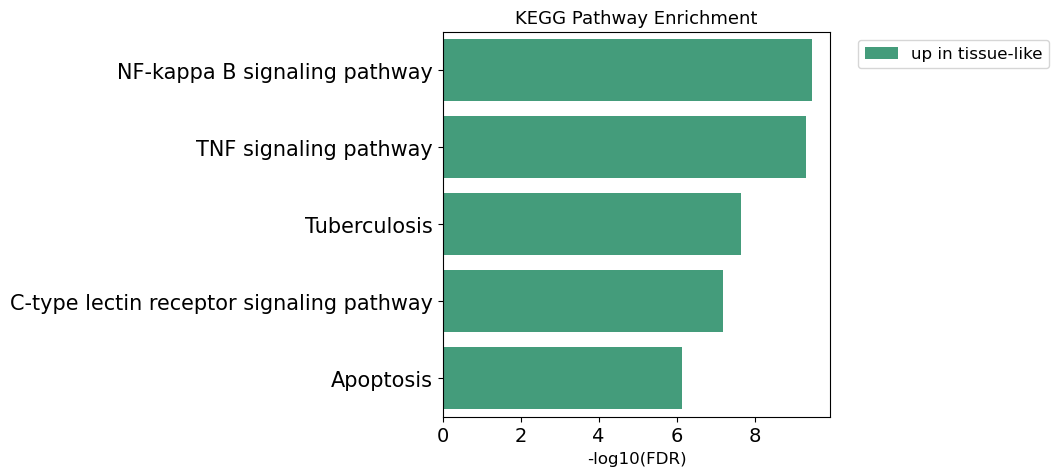

In [81]:
palette = {"up in blood-like": "#E18514", "up in tissue-like": "#36AA7F"}

# Plot KEGG
plt.figure(figsize=(5,5))
sns.barplot(
    data=kegg_up,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    #size="Overlap",
    #sizes=(50, 200),
    #legend="full",
    palette=palette,
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.title("KEGG Pathway Enrichment", fontsize=13)
plt.xlabel("-log10(FDR)", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=14)
plt.yticks(fontsize=15)
# Adjust horizontal alignment manually
#for label in plt.gca().get_yticklabels():
    #label.set_horizontalalignment("right")  # or "left", "right"
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

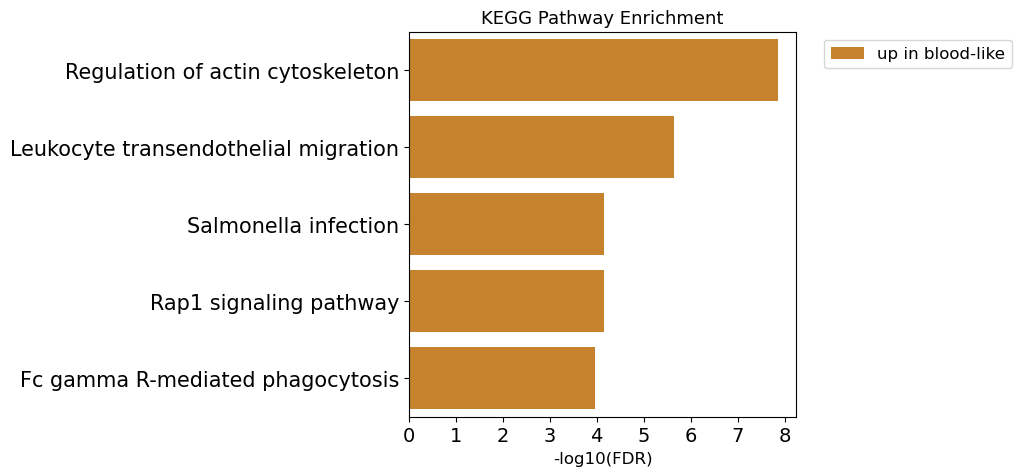

In [82]:
## palette = {"up in blood-like": "#E18514", "up in tissue-like": "#36AA7F"}

# Plot KEGG
plt.figure(figsize=(5,5))
sns.barplot(
    data=kegg_dwn,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    #size="Overlap",
    #sizes=(50, 200),
    #legend="full",
    palette=palette,
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.title("KEGG Pathway Enrichment", fontsize=13)
plt.xlabel("-log10(FDR)", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=14)
plt.yticks(fontsize=15)
# Adjust horizontal alignment manually
#for label in plt.gca().get_yticklabels():
    #label.set_horizontalalignment("right")  # or "left", "right"
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [83]:
# Sort GO-BP results by significance for consistent plotting
go_up = go_up.sort_values("-log10(FDR)", ascending=False)
go_dwn = go_dwn.sort_values("-log10(FDR)", ascending=False)

# Set y-axis order to match sorting
go_up["Term"] = pd.Categorical(go_up["Term"], categories=go_up["Term"].unique()[::-1], ordered=True)
go_dwn = go_dwn.dropna(subset=["Term"])
go_dwn["Term"] = pd.Categorical(
    go_dwn["Term"], 
    categories=go_dwn["Term"].unique()[::-1], 
    ordered=True
)

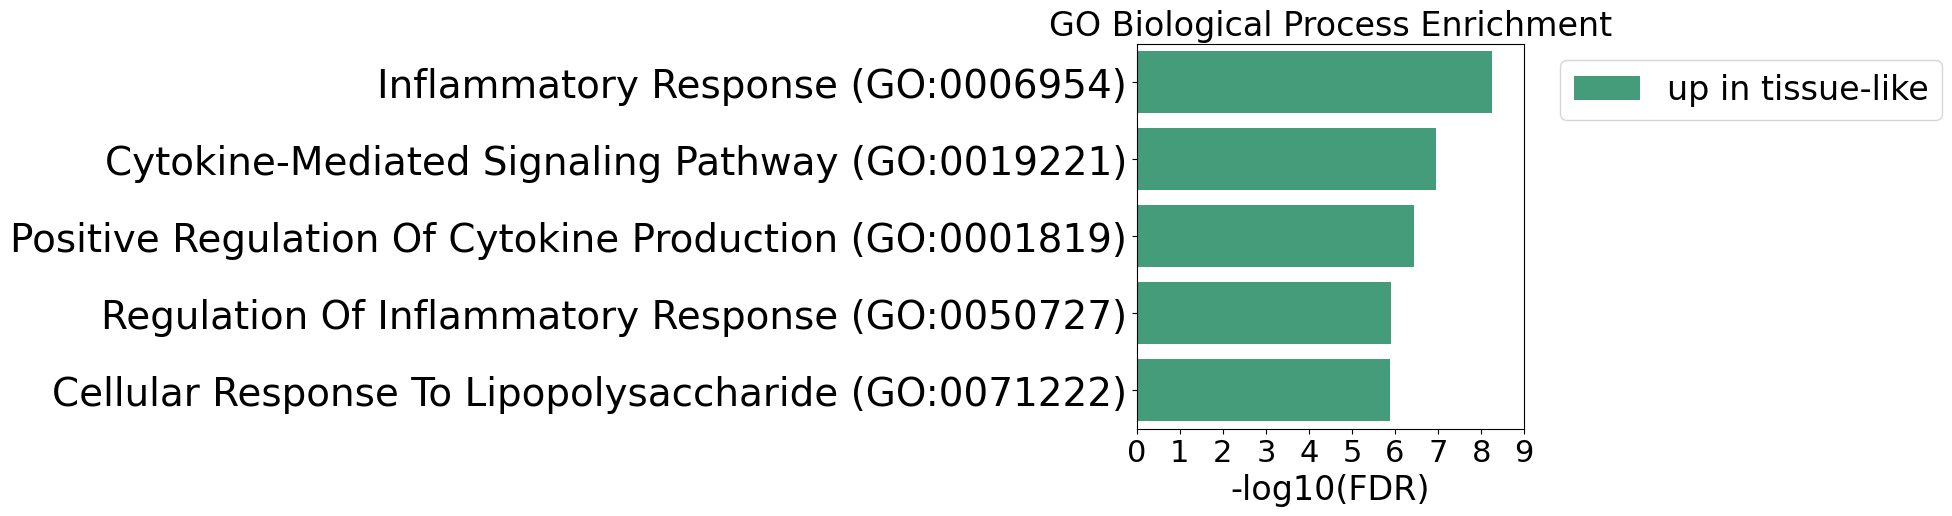

In [84]:
# Plot GO-BP with extra space
plt.figure(figsize=(5, 5))  # Wider + taller for long terms
sns.barplot(
    data=go_up,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    palette=palette,
)

# Font settings
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=24)
plt.title("GO Biological Process Enrichment", fontsize=24)
plt.xlabel("-log10(FDR)", fontsize=24)
plt.ylabel("")
plt.xticks(ticks=np.arange(0, int(np.ceil(go_up["-log10(FDR)"].max())) + 1, 1), fontsize=22)
plt.yticks(fontsize=28)

# Invert y-axis for correct order
plt.gca().invert_yaxis()

# 🔧 Increase left margin to prevent y-tick label clipping
#plt.subplots_adjust(left=0.7)

plt.tight_layout()
plt.show()

In [85]:
# Plot GO-BP with extra space
plt.figure(figsize=(5, 5))  # Wider + taller for long terms
sns.barplot(
    data=go_dwn,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    palette=palette,
)

# Font settings
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=24)
plt.title("GO Biological Process Enrichment", fontsize=24)
plt.xlabel("-log10(FDR)", fontsize=24)
plt.ylabel("")
plt.xticks(ticks=np.arange(0, int(np.ceil(go_up["-log10(FDR)"].max())) + 1, 1), fontsize=22)
plt.yticks(fontsize=28)

# Invert y-axis for correct order
plt.gca().invert_yaxis()

# 🔧 Increase left margin to prevent y-tick label clipping
#plt.subplots_adjust(left=0.7)

plt.tight_layout()
plt.show()

ValueError: min() arg is an empty sequence

<Figure size 500x500 with 0 Axes>

aim: determine the number of cells expressing genes involved in specific enriched pathway

In [88]:
# Find row for Apoptosis pathway
apoptosis_row = enr_up.results[(enr_up.results["Term"] == "Apoptosis") & 
                               (enr_up.results["Gene_set"] == "KEGG_2019_Mouse")]

# Extract genes
apoptosis_genes = apoptosis_row["Genes"].values[0].split(";")


In [89]:
# Keep only genes found in your 7-day data
valid_apoptosis_genes = [gene for gene in apoptosis_genes if gene in wound_7day_bt.var_names]
print(f"{len(valid_apoptosis_genes)} apoptosis pathway genes found in the 7-day dataset.")


0 apoptosis pathway genes found in the 7-day dataset.


In [90]:
print(wound_7day_bt.var_names[:10])

Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610009E02Rik',
       '0610009L18Rik', '0610012D04Rik', '0610012G03Rik', '0610030E20Rik',
       '0610038B21Rik', '0610039K10Rik'],
      dtype='object')


In [91]:
# View raw gene string from Apoptosis row
print(enr_up.results[enr_up.results["Term"] == "Apoptosis"]["Genes"].values[0])


NFKBIA;TUBA1C;BCL2L11;GADD45B;CSF2RB;TRAF1;TNF;NFKB1;BCL2L1;LMNB1;CTSB;BIRC3


In [93]:
# Get raw gene string for Apoptosis from enr_up
apoptosis_genes_raw = enr_up.results[
    (enr_up.results["Term"] == "Apoptosis") &
    (enr_up.results["Gene_set"] == "KEGG_2019_Mouse")
]["Genes"].values[0]

# Convert to mouse-style gene symbols
apoptosis_genes_mouse = [gene.strip().capitalize() for gene in apoptosis_genes_raw.split(';')]

# Check the converted list
print("Converted Apoptosis genes to mouse-like format:")
print(apoptosis_genes_mouse)

Converted Apoptosis genes to mouse-like format:
['Nfkbia', 'Tuba1c', 'Bcl2l11', 'Gadd45b', 'Csf2rb', 'Traf1', 'Tnf', 'Nfkb1', 'Bcl2l1', 'Lmnb1', 'Ctsb', 'Birc3']


In [94]:
# Match converted genes to genes in your dataset
valid_apoptosis_genes = [gene for gene in apoptosis_genes_mouse if gene in wound_7day_bt.var_names]
print(f"{len(valid_apoptosis_genes)} apoptosis pathway genes matched in the dataset.")
print("Matched genes:", valid_apoptosis_genes)


12 apoptosis pathway genes matched in the dataset.
Matched genes: ['Nfkbia', 'Tuba1c', 'Bcl2l11', 'Gadd45b', 'Csf2rb', 'Traf1', 'Tnf', 'Nfkb1', 'Bcl2l1', 'Lmnb1', 'Ctsb', 'Birc3']


In [95]:
X_apoptosis = wound_7day_bt[:, valid_apoptosis_genes].X
X_binary = (X_apoptosis > 0).astype(int)
apoptosis_gene_count = np.array(X_binary.sum(axis=1)).flatten()

# Count how many cells express ≥ 2 apoptosis genes
threshold = 2
cells_with_apoptosis = np.sum(apoptosis_gene_count >= threshold)

print(f"{cells_with_apoptosis} cells express at least {threshold} apoptosis genes.")


224 cells express at least 2 apoptosis genes.


In [105]:
import numpy as np

# Calculate mean expression of apoptosis genes in each time point
mean_expr_24hr = np.array(wound_24hr_bt[:, valid_apoptosis_genes].X.mean(axis=0)).flatten()
mean_expr_7day = np.array(wound_7day_bt[:, valid_apoptosis_genes].X.mean(axis=0)).flatten()

import pandas as pd
df = pd.DataFrame({
    "gene": valid_apoptosis_genes,
    "mean_expr_24hr": mean_expr_24hr,
    "mean_expr_7day": mean_expr_7day,
})
df["log2FC"] = np.log2((df["mean_expr_7day"] + 1e-3) / (df["mean_expr_24hr"] + 1e-3))
df.sort_values("log2FC", ascending=False)


,gene,mean_expr_24hr,mean_expr_7day,log2FC
6,Actg1,2.950839,2.632324,-0.164729
3,Gadd45b,0.696695,0.579690,-0.264830
0,Nfkbia,1.515682,1.224666,-0.307352
4,Csf2rb,1.757659,1.386289,-0.342207
2,Bcl2l11,0.823430,0.647541,-0.346198
5,Tnf,0.489203,0.378933,-0.367633
1,Tuba1c,0.729992,0.504323,-0.532650
8,Lmnb1,2.093570,1.416779,-0.563022
7,Bcl2l1,0.456527,0.283936,-0.683220
